In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import time
import copy
import operator
import numpy as np
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import imageio

# Suggestion Engine Prototype

Minimizing the distance between reality and goals

provide goals and current gym status and then get and implement route suggestions given by the engine

Contrast with a pure mathematical approach of minimizing the N-dimensional distance

## Methodology

- Each column will represent a field. 
- We will use 1 hot representation. 
- A gym will be a stacked collection of routes
- We can know the mean of any category by summing and dividing by the rows.
- The goals are stored the same way, so we can get the distance between each field

## How the array looks

- 0-5: Styles: [balance,toe-hooking,heel-hooking,finger-strength,powerful]
- 5-10: Techniques: [balance,toe-hooking,heel-hooking,finger-strength,powerful]
- 10-15: grade: [blue,pink,purple,green,yellow]
- 15-18: length: [short,medium,long]
- 18-23: R: [1,2,3,4,5]
- 23-28: I: [1,2,3,4,5]
- 28-33: C: [1,2,3,4,5]
- 33-38: Location: [wave-wall,barrel,roof,accordian,shield]


In [2]:
route_dictionary = {0:'balance',
                   1:'toe-hooking',
                   2:'heel-hooking',
                   3:'finger-strength',
                   4:'powerful',
                    
                   5:'balance',
                   6:'toe-hooking',
                   7:'heel-hooking',
                   8:'finger-strength',
                   9:'powerful',
                    
                    10:'blue',
                    11:'pink',
                    12:'purple',
                    13:'green',
                    14:'yellow',
                    
                    15:'short',
                    16:'medium',
                    17:'long',
                    
                    18:'1',
                    19:'2',
                    20:'3',
                    21:'4',
                    22:'5',
                    
                    23:'1',
                    24:'2',
                    25:'3',
                    26:'4',
                    27:'5',
                    
                    28:'1',
                    29:'2',
                    30:'3',
                    31:'4',
                    32:'5',
                    
                    33:'wave-wall',
                    34:'barrel',
                    35:'roof',
                    36:'accordian',
                    37:'shield'
                   }

array_dictionary = np.array(['balance','toe-hooking','heel-hooking','finger-strength','powerful',\
                    'balance','toe-hooking','heel-hooking','finger-strength','powerful',
                    'blue','pink','purple','green','yellow',
                     'short','medium','long',
                     '1','2','3','4','5',
                    '1','2','3','4','5',
                    '1','2','3','4','5',
                    'wave-wall','barrel','roof','accordian','shield'])

def convert_array_to_readable(array):
    mask = np.where(array > 0)[0]
    return array_dictionary[mask]

In [3]:
"""
Gen ints between 0-5,5-10,10-15,15-18,18-23,23-28,28-33,33-38

can gen multiple in a given category for instance multiple styles
"""

def gen_random_route(num_routes):
    routes = np.zeros((num_routes,38))
    for n in range(num_routes):
        style = np.random.choice(np.arange(0,5))
        technique = np.random.choice(np.arange(5,10))
        grade = np.random.choice(np.arange(10,15))
        length = np.random.choice(np.arange(15,18))
        R = np.random.choice(np.arange(18,23))
        I = np.random.choice(np.arange(23,28))
        C = np.random.choice(np.arange(28,33))
        Location = np.random.choice(np.arange(33,38))
        mask = np.array([style,technique,grade,length,R,I,C,Location])
        routes[n][mask] = 1
    return routes

In [4]:
def make_default_goals(num_routes):
    goals = np.zeros(38)
    by_5 = num_routes / 5
    by_3 = num_routes / 3
    styles = by_5
    techniques = by_5
    grades = by_5
    length = by_3
    R = by_5
    I = by_5
    C = by_5
    Location = by_5
    
    goals[0:5] = np.full(5,styles)
    goals[5:10] = np.full(5,techniques)
    goals[10:15] = np.full(5,grades)
    goals[15:18] = np.full(3,length)
    goals[18:23] = np.full(5,R)
    goals[23:28] = np.full(5,I)
    goals[28:33] = np.full(5,C)
    goals[33:38] = np.full(5,Location)
    return goals

def random_num(max_num,N):
    arr = np.zeros(N)
    arr[0] = np.random.random() * max_num
    max_num -= arr[0]
    for i in range(1,N-1):
        arr[i] = np.random.random() * max_num
        max_num -= arr[i]
    arr[-1] = max_num
    return arr

def gen_random_goals(num_routes):
    goals = np.zeros(38)
    
    styles = random_num(num_routes,5)
    techniques = random_num(num_routes,5)
    grades = random_num(num_routes,5)
    length = random_num(num_routes,3)
    R = random_num(num_routes,5)
    I = random_num(num_routes,5)
    C = random_num(num_routes,5)
    Location = random_num(num_routes,5)
    
    goals[0:5] = styles
    goals[5:10] = techniques
    goals[10:15] = grades
    goals[15:18] = length
    goals[18:23] = R
    goals[23:28] = I
    goals[28:33] = C
    goals[33:38] = Location
    return goals

## Test functions

In [5]:
# Test readable
mask = np.array([1,6,11,16,20,24,32,35])

arr_route = np.zeros(38)
arr_route[mask] = 1
readable_array = convert_array_to_readable(arr_route)
    
# Test ran gen
ran_routes = gen_random_route(5)
print('ran_routes',ran_routes.shape)
readable_routes = [convert_array_to_readable(route) for route in ran_routes]
print('readable_routes',readable_routes)

# test random num gen for goals
styles = random_num(5,5)
print('styles',styles,np.sum(styles))

# Test default goal gen
goals = make_default_goals(5)
print(goals)

# test random goals
ran_goals = gen_random_goals(5)
print('ran goals',ran_goals)

ran_routes (5, 38)
readable_routes [array(['powerful', 'toe-hooking', 'green', 'short', '2', '2', '1',
       'wave-wall'], dtype='<U15'), array(['toe-hooking', 'finger-strength', 'green', 'long', '2', '2', '4',
       'shield'], dtype='<U15'), array(['heel-hooking', 'heel-hooking', 'purple', 'short', '5', '4', '2',
       'barrel'], dtype='<U15'), array(['balance', 'toe-hooking', 'blue', 'short', '3', '3', '2',
       'accordian'], dtype='<U15'), array(['finger-strength', 'toe-hooking', 'pink', 'long', '2', '5', '1',
       'accordian'], dtype='<U15')]
styles [3.62321185 0.68733468 0.57108619 0.02722946 0.09113782] 5.0
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.66666667 1.66666667 1.66666667
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.       

## Gym class

To hold the current distribution of routes. And the goals of the gym, and return the L2 distance

In [6]:
class Gym(object):
    def __init__(self,routes,goals):
        self.routes = routes
        self.goals = goals
        self.index = 0
    
    def update_route(self,route):
        self.routes[self.index][:] = route
        self.index = (self.index + 1) % len(self)
        
    def delete_route(self):
        pass
        
    def get_route(self,index):
        return Gym.convert_array_to_readable(self.routes[index])
    
    @staticmethod
    def convert_array_to_readable(array):
        mask = np.where(array > 0)[0]
        return array_dictionary[mask]
    
    @property
    def get_index(self):
        return self.index
        
    @property
    def distance(self):
        # mean columns in routes
        current_dist = np.sum(self.routes,axis = 0)
        nd_distance = self.goals - current_dist
        return nd_distance
    
    @property
    def loss(self):
        current_dist = np.sum(self.routes,axis = 0)
        nd_distance = self.goals - current_dist
        return np.sum((nd_distance)**2)
    
    def __len__(self):
        # Return number of routes
        return self.routes.shape[0]

# Test Gym class

In [7]:
routes = gen_random_route(10)
goals = gen_random_goals(10)

elevation = Gym(routes,goals)

In [8]:
print('Goal shape',goals.shape)
print('routes shape',routes.shape)
print('Number of routes',len(elevation))
print('5th route',elevation.get_route(5))
print('distance',elevation.distance)
print('routes',np.sum(routes,axis=0))
print('goals',goals)

Goal shape (38,)
routes shape (10, 38)
Number of routes 10
5th route ['finger-strength' 'powerful' 'green' 'short' '4' '3' '3' 'accordian']
distance [-3.47968480e-01  1.86068851e+00  1.13365535e+00 -2.85496150e+00
  2.08586126e-01  4.68293107e+00 -2.93359941e+00 -8.44067015e-01
 -7.22761347e-02 -8.32988503e-01  5.85411466e+00 -1.15857857e-01
 -2.63521340e+00 -2.95541347e+00 -1.47629939e-01 -2.91848674e+00
 -2.36050253e-02  2.94209176e+00  5.13940040e+00  7.11147287e-01
 -8.73853730e-01 -9.82091874e-01 -3.99460209e+00  1.92301983e-01
  2.98395545e+00 -1.54136257e-01 -2.74094621e+00 -2.81174970e-01
  6.63989029e+00 -6.77897149e-01 -1.99009694e+00  6.50846843e-03
 -3.97840468e+00 -1.93750391e+00  3.77789306e+00 -8.80255369e-01
 -2.94128623e+00  1.98115245e+00]
routes [3. 1. 1. 3. 2. 1. 5. 1. 2. 1. 1. 2. 3. 3. 1. 5. 2. 3. 2. 2. 1. 1. 4. 1.
 0. 2. 3. 4. 2. 1. 3. 0. 4. 2. 2. 2. 3. 1.]
goals [2.65203152e+00 2.86068851e+00 2.13365535e+00 1.45038499e-01
 2.20858613e+00 5.68293107e+00 2.06640059

# Network

In [11]:
class Network(nn.Module):
    def __init__(self,state_space,seed,hidden_dims=(32,32),activation_fc=F.relu):
        super(Network,self).__init__()
        self.activation_fc = activation_fc
        self.seed = torch.manual_seed(seed)
        self.input_layer = nn.Linear(state_space,hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i],hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        
        # Outputs, we softmax over the various classes for 1 per class (can change this for multi class)
        self.style = nn.Linear(hidden_dims[-1],5)
        self.techniques = nn.Linear(hidden_dims[-1],5)
        self.grades = nn.Linear(hidden_dims[-1],5)
        self.length = nn.Linear(hidden_dims[-1],3)
        self.R = nn.Linear(hidden_dims[-1],5)
        self.I = nn.Linear(hidden_dims[-1],5)
        self.C = nn.Linear(hidden_dims[-1],5)
        self.Location = nn.Linear(hidden_dims[-1],5)
        
    def forward(self,state):
        x = state
        if not isinstance(state,torch.Tensor):
            x = torch.tensor(x,dtype=torch.float32) #device = self.device,
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
            
        # Outputs
        S = F.softmax(self.style(x),dim=1)
        T = F.softmax(self.techniques(x),dim=1)
        G = F.softmax(self.grades(x),dim=1)
        L = F.softmax(self.length(x),dim=1)
        R = F.softmax(self.R(x),dim=1)
        I = F.softmax(self.I(x),dim=1)
        C = F.softmax(self.C(x),dim=1)
        Location = F.softmax(self.Location(x),dim=1)
        # Cat outputs
        route = torch.cat([S,T,G,L,R,I,C,Location],dim=1)
#         log_probs = torch.log(route)
        return route

In [12]:
state_space = 38
seed = 1234
suggestion_engine = Network(state_space,seed)
optimizer = optim.Adam(suggestion_engine.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

## Test network outputs

In [13]:
test_routes = gen_random_route(10)
output = suggestion_engine(test_routes[0]).squeeze(0)
# print('output[:5]',output.detach().cpu().numpy()[:5])
# print('output[5:10]',output.detach().cpu().numpy()[5:10])
print('output',output,output.shape)
# print('output[:5]',np.sum(output.detach().cpu().numpy()[:5]))
# print('output[5:10]',np.sum(output.detach().cpu().numpy()[5:10]))
print('distance',elevation.distance)
print('loss',elevation.loss)

output tensor([0.1983, 0.1974, 0.1862, 0.1953, 0.2228, 0.2247, 0.1609, 0.2183, 0.2096,
        0.1865, 0.2067, 0.1998, 0.1958, 0.1872, 0.2106, 0.3223, 0.3739, 0.3038,
        0.1908, 0.1959, 0.1936, 0.2144, 0.2054, 0.2188, 0.2058, 0.1970, 0.1883,
        0.1901, 0.1973, 0.1879, 0.2132, 0.1887, 0.2129, 0.2084, 0.2044, 0.1804,
        0.1924, 0.2144], grad_fn=<SqueezeBackward1>) torch.Size([38])
distance [-3.47968480e-01  1.86068851e+00  1.13365535e+00 -2.85496150e+00
  2.08586126e-01  4.68293107e+00 -2.93359941e+00 -8.44067015e-01
 -7.22761347e-02 -8.32988503e-01  5.85411466e+00 -1.15857857e-01
 -2.63521340e+00 -2.95541347e+00 -1.47629939e-01 -2.91848674e+00
 -2.36050253e-02  2.94209176e+00  5.13940040e+00  7.11147287e-01
 -8.73853730e-01 -9.82091874e-01 -3.99460209e+00  1.92301983e-01
  2.98395545e+00 -1.54136257e-01 -2.74094621e+00 -2.81174970e-01
  6.63989029e+00 -6.77897149e-01 -1.99009694e+00  6.50846843e-03
 -3.97840468e+00 -1.93750391e+00  3.77789306e+00 -8.80255369e-01
 -2.94128

In [14]:
def route_from_suggestion(suggestion):
    route = np.zeros(38)
    
    styles = suggestion[0:5] 
    techniques     = suggestion[5:10] 
    grades     = suggestion[10:15] 
    length     = suggestion[15:18] 
    R     = suggestion[18:23] 
    I     = suggestion[23:28] 
    C     = suggestion[28:33] 
    Location     = suggestion[33:38] 
    
    values_5 = np.arange(5)
    values_3 = np.arange(3)
    
    route_style = np.random.choice(values_5,p=styles)
    route_techniques = np.random.choice(values_5,p=techniques) + 5
    route_grades = np.random.choice(values_5,p=grades) + 10
    route_length = np.random.choice(values_3,p=length) + 15
    route_R = np.random.choice(values_5,p=R) + 18
    route_I = np.random.choice(values_5,p=I) + 23
    route_C = np.random.choice(values_5,p=C) + 28
    route_Locations = np.random.choice(values_5,p=Location) + 33
    
    mask = np.array([route_style,route_techniques,route_grades,\
                           route_length,route_R,route_I,route_C,route_Locations])
#     print('mask',mask)
    route[mask] = 1
    return route

# Math create next route

For comparison

- minus means we need to get rid of
- plus means we need to boost occurances of

In [15]:
def route_from_distance(distance):
    route = np.zeros(38)
    
    styles = distance[0:5] 
    techniques     = distance[5:10] 
    grades     = distance[10:15] 
    length     = distance[15:18] 
    R     = distance[18:23] 
    I     = distance[23:28] 
    C     = distance[28:33] 
    location     = distance[33:38] 
    
    r_styles = np.where(styles == np.max(styles))[0]
    r_techniques = np.where(techniques == np.max(techniques))[0] + 5
    r_grades = np.where(grades == np.max(grades))[0] + 10
    r_length = np.where(length == np.max(length))[0] + 15
    r_R = np.where(R == np.max(R))[0] + 18
    r_I = np.where(I == np.max(I))[0] + 23
    r_C = np.where(C == np.max(C))[0] + 28
    r_location = np.where(location == np.max(location))[0] + 33
    
    mask = np.array([r_styles,r_techniques,r_grades,r_length,r_R,r_I,r_C,r_location])
#     print(mask)
    route[mask] = 1
    return route

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def probabilistic_route(distance):
    route = np.zeros(38)
    epsilon = 0
    arr_5 = np.arange(5)
    arr_3 = np.arange(3)
    
    styles = distance[0:5] 
    techniques     = distance[5:10] 
    grades     = distance[10:15] 
    length     = distance[15:18] 
    R     = distance[18:23] 
    I     = distance[23:28] 
    C     = distance[28:33] 
    location     = distance[33:38] 
    
    r_style_prob = softmax(styles+np.abs(np.min(styles))+epsilon)
    r_tech_prob = softmax(techniques+np.abs(np.min(techniques))+epsilon)
    r_grad_prob = softmax(grades+np.abs(np.min(grades))+epsilon)
    length_prob = softmax(length+np.abs(np.min(length))+epsilon)
    r_prob = softmax(R+np.abs(np.min(R))+epsilon)
    i_prob =softmax(I+np.abs(np.min(I))+epsilon)
    c_prob = softmax(C+np.abs(np.min(C))+epsilon)
    loc_prob = softmax(location+np.abs(np.min(location))+epsilon)
    
    r_styles = np.random.choice(arr_5,p=r_style_prob)
    r_techniques = np.random.choice(arr_5,p=r_tech_prob) + 5
    r_grades = np.random.choice(arr_5,p=r_grad_prob) + 10
    r_length = np.random.choice(arr_3,p=length_prob) + 15
    r_R = np.random.choice(arr_5,p=r_prob) + 18
    r_I = np.random.choice(arr_5,p=i_prob) + 23
    r_C = np.random.choice(arr_5,p=c_prob) + 28
    r_location = np.random.choice(arr_5,p=loc_prob) + 33
    
    mask = np.array([r_styles,r_techniques,r_grades,r_length,r_R,r_I,r_C,r_location])
#     print(mask)
    route[mask] = 1
    return route

In [16]:
# Test route_from_distance
# route_from_distance(elevation.L2)

In [26]:
def train(config,func):
    scores = []
    for e in range(config.episodes):
        episode_scores = []
        routes = gen_random_route(10)
        goals = gen_random_goals(10)
        elevation = Gym(routes,goals)
        for i in range(config.tmax):
            # Record loss and distance
            state = elevation.distance
            prev_loss = elevation.loss
            # Pass distance into math
#             route = route_from_distance(state)
            route = func(state)
            # Update gym
            elevation.update_route(route)
            # Get new loss
            loss = elevation.loss
            episode_scores.append(loss)
#             print('value of step',loss-prev_loss)
        scores.append(loss)
    return scores,episode_scores

In [27]:
class Config(object):
    def __init__(self,episodes,tmax):
        self.episodes = episodes
        self.tmax = tmax

In [28]:
episodes = 70
tmax = 50

config = Config(episodes,tmax)

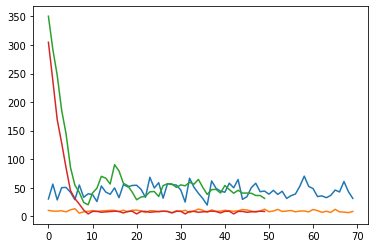

In [29]:
scores,episode_scores = train(config,probabilistic_route)
scores1,episode_scores1 = train(config,route_from_distance)

plt.plot(scores)
plt.plot(scores1)
plt.plot(episode_scores)
plt.plot(episode_scores1)

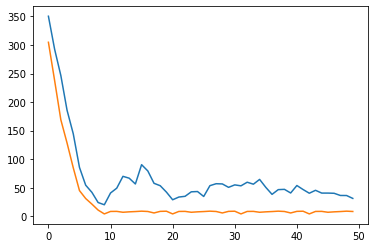

In [30]:

plt.plot(episode_scores)
plt.plot(episode_scores1)

# Train the network

- Loss is the difference in loss between the previous route distribution and the current one.
- We want to increase/decrease the log probability of choosing that 'action/distribution' based on the loss difference.
- We update the log probs with the gradiant of the outcome


In [41]:
def train_network(policy,optimizer,config):
    scores = []
    for e in range(config.episodes):
        routes = gen_random_route(10)
        goals = gen_random_goals(10)
        elevation = Gym(routes,goals)
        starting_loss = elevation.loss
        for i in range(config.tmax):
#             current_dist = np.sum(elevation.routes,axis = 0)
#             nd_distance = elevation.goals - current_dist
#             prev_loss = np.mean((nd_distance)**2)
#             print('prev_loss',prev_loss)
            # Record loss and distance
            state = elevation.L2
            prev_loss = elevation.loss
#             print('prev_loss',prev_loss)
            # Pass distance into network
            suggestion = policy(state)
            # Get route from suggestion
            route = route_from_suggestion(suggestion.detach().cpu().squeeze(0).numpy())
            # Update gym
            elevation.update_route(route)
            # Get new loss
            loss = elevation.loss
            print('loss',loss)
            # Get improvement
#             route_loss = -torch.from_numpy(np.array(loss - prev_loss))
            log_probs = torch.log(suggestion).float()
            grad = -(torch.from_numpy(state).float() * log_probs).mean()
#             grad = (difference * route_loss).mean()
            
            
#             print('loss - prev_loss',loss - prev_loss)
#             print('route_loss',route_loss)
#             print('state',state)
#             print('suggestion',suggestion)
#             print('log prob',log_probs)
# #             print('difference',difference)
#             print('grad',grad)
#             asdf
            optimizer.zero_grad()
            grad.backward()
            nn.utils.clip_grad_norm_(policy.parameters(), 10)
            optimizer.step()
        scores.append((loss - starting_loss))
        print('starting_loss',starting_loss)
        print('end loss',loss)
    return policy,scores

In [42]:
state_space = 38
seed = 1234
suggestion_engine = Network(state_space,seed)
optimizer = optim.Adam(suggestion_engine.parameters(), lr=1e-4)

In [43]:
tic = time.time()
policy,scores = train_network(suggestion_engine,optimizer,config)
toc = time.time()
print('time taken {}'.format((toc-tic)/60))

loss 284.4908110909807
loss 283.7711379015903
loss 311.50413879199914
loss 318.60223405770967
loss 339.4598602630803
loss 380.9876012657285
loss 404.00038327747217
loss 436.9934024877403
loss 431.2107150618961
loss 445.46120655935397
loss 422.49643120167275
loss 442.27369246898434
loss 425.79610862640004
loss 447.49653628396
loss 443.18398978513255
loss 427.90296043115234
loss 431.287326634852
loss 416.8862857997427
loss 436.8628126843084
loss 416.0723586529896
loss 422.5476641211689
loss 413.6734474984199
loss 393.436889452751
loss 366.6359511060517
loss 378.0097216982921
loss 363.80281468143005
loss 364.71425931764094
loss 373.74333839592003
loss 352.0576289537939
loss 385.75734534869537
loss 408.0071485346689
loss 430.0297326145985
loss 383.2807166590192
loss 412.75886407970836
loss 401.53017873583633
loss 463.60837370562433
loss 494.58202646355306
loss 470.6086080577238
loss 459.0254833350159
loss 447.7006972276175
loss 441.6300601248152
loss 433.80912490721613
loss 486.58475153069

loss 317.4164221685812
loss 289.84792707301983
loss 273.10440744903053
loss 258.00375787209987
loss 283.71106264083505
loss 276.93868051439244
loss 271.2528720674822
loss 272.82705383180655
loss 243.93174136487477
loss 240.40405630738098
loss 199.5181118848288
loss 174.52449745037882
loss 176.71520135803922
loss 143.59478062690886
loss 141.10225485555773
loss 144.40488947124877
loss 153.83034791008328
loss 150.00170363472066
loss 187.6531577809614
loss 155.32144545484587
loss 196.51019207294587
loss 191.32691175563806
loss 167.39425543290105
loss 189.58014601153582
loss 194.71051145936346
loss 181.50255018036503
loss 179.89993470350277
loss 167.5009711956552
loss 150.26344549347704
loss 175.0291180007883
loss 192.19079554083658
loss 193.27107711630865
loss 183.81140894753358
loss 198.0135802394457
loss 189.78408883931908
loss 208.62164415320836
loss 209.80670125462402
loss 249.9218182410204
loss 249.8797504212005
loss 235.1220684363338
loss 236.6550933743801
loss 256.4358087894281
loss

loss 204.27462581509994
loss 207.11246499463877
loss 215.2017917658251
loss 217.08414244437796
loss 231.18743247651645
loss 252.03286385921803
loss 256.38324969267205
loss 243.26336930416068
loss 269.20150679048237
loss 253.772617452252
loss 242.31817543032435
loss 228.72603272610525
loss 224.19561129591455
loss 213.98949470813662
loss 212.87347881457995
loss 220.52555921784872
loss 204.16950277526095
loss 200.8810909463627
loss 197.05414752143105
loss 191.38968947847835
loss 182.79052572956806
loss 183.7184660778803
loss 181.8471104727203
loss 191.54957038858075
starting_loss 391.566444563351
end loss 191.54957038858075
loss 214.43988872053305
loss 194.0760008150643
loss 162.58914760226457
loss 140.88124964265202
loss 121.77008221355963
loss 128.23101709248743
loss 106.23374483168335
loss 137.13564502628978
loss 125.09176940181919
loss 135.1860368390188
loss 131.34283002893875
loss 153.61815784838586
loss 129.42153347625603
loss 146.07900618156987
loss 145.84095216798792
loss 143.4324

loss 160.66421974888857
loss 131.22855386246164
loss 105.61734818653494
loss 118.91943016405256
loss 123.92071498156443
loss 154.92499720791488
loss 156.7932054253948
loss 176.97623487497847
loss 159.18488043029203
loss 205.79127402680663
loss 209.19247108075749
loss 225.1295440983771
loss 245.98395284530514
loss 234.51170527105532
loss 245.75557849757075
loss 251.18240481808448
loss 263.912244833407
loss 247.134051028794
loss 249.26452208811045
loss 222.47728190391123
loss 209.18462692928375
loss 186.01102170769153
starting_loss 287.1137282199441
end loss 186.01102170769153
loss 275.2533044470228
loss 285.7664010979828
loss 244.09770627441497
loss 228.8171977163351
loss 208.69020443838963
loss 216.70602187667023
loss 199.58380850237629
loss 209.72137820597382
loss 203.57926343016186
loss 199.21741138560512
loss 187.54894914951257
loss 210.8224780319066
loss 210.3892822468486
loss 244.73304647043454
loss 291.9912839726438
loss 266.21874579944097
loss 290.92014924691443
loss 277.7195794

loss 170.09298402417107
loss 155.10405805063226
loss 153.06549354267696
loss 153.8355772740009
loss 143.4039976466553
starting_loss 419.5486396202276
end loss 143.4039976466553
loss 234.7497225862117
loss 213.91462208344706
loss 199.77076125714217
loss 214.37204283689016
loss 201.77019509033738
loss 179.0272134063672
loss 193.03941500642998
loss 189.64326142135158
loss 188.26753191674888
loss 182.0133100150679
loss 212.66605292048945
loss 223.40648047734382
loss 246.86208590828414
loss 229.7951296518408
loss 218.58390119006413
loss 238.0632165850486
loss 198.78197172446517
loss 213.43124203758447
loss 216.88874255197217
loss 215.50955534725853
loss 186.4241292818788
loss 194.1303336381469
loss 162.3677882552831
loss 177.2739411488844
loss 178.00712265608198
loss 173.9499042522435
loss 142.59625843181087
loss 125.23745527418123
loss 124.07485848759717
loss 147.07525385561783
loss 174.31612480508676
loss 177.58879831487013
loss 216.96809744336832
loss 204.14962880315503
loss 243.82128938

loss 193.82677526665913
loss 171.41809750276892
loss 187.69241923184936
loss 159.67477392817725
loss 149.89256108152463
loss 172.8496132575793
loss 147.72138344602854
loss 168.6765682940062
loss 161.73036493177122
loss 184.85726026486455
loss 186.3734128705987
loss 201.3071660582186
loss 221.87031175040497
loss 210.00276688207992
loss 218.5811225255846
loss 218.80142589281064
loss 218.28219099922444
loss 190.40042772342895
loss 205.0642385426908
loss 229.4548152390709
starting_loss 202.8279649010903
end loss 229.4548152390709
loss 304.4463587450917
loss 295.7245553416626
loss 272.9407008089363
loss 239.25192112611157
loss 250.07848479800657
loss 254.73735497014087
loss 248.47000168315037
loss 231.76231121197233
loss 217.97840233905782
loss 217.76659875582666
loss 208.50703205281062
loss 200.58868589170316
loss 175.2226185706682
loss 185.8975920139818
loss 194.7665328184801
loss 179.4086043375607
loss 188.69807685737217
loss 218.96228872213635
loss 174.45753679551513
loss 162.6973190686

loss 98.60396241652377
loss 105.6433788074473
loss 121.01420215721154
loss 126.83423692951999
loss 125.72029327107975
loss 115.40314060986537
loss 92.64112262761297
loss 78.6932545379096
loss 81.28980787428327
loss 65.11102263889545
loss 73.47332298732175
loss 60.67209834649676
loss 70.85557904131781
loss 92.68898354027499
starting_loss 265.90742337185975
end loss 92.68898354027499
loss 208.76249041080476
loss 209.7878455641945
loss 219.67844314634647
loss 240.83958573409484
loss 242.11314289995462
loss 270.2543971810539
loss 256.6598396899391
loss 263.6037848641312
loss 223.53551601331293
loss 228.45960906602897
loss 199.12403717614708
loss 214.20447355088106
loss 229.49780389635768
loss 227.24141016757142
loss 215.4881547369674
loss 217.45123394235463
loss 198.5323958002882
loss 217.7623233677201
loss 216.7961275801989
loss 184.73356520251386
loss 198.54129578758824
loss 203.26490469020334
loss 218.72681256314445
loss 215.06383758420185
loss 223.97136770701417
loss 204.7771883074323


loss 184.9933347031095
loss 180.43919476470055
loss 156.7442610555811
loss 157.36052510913999
loss 150.55219783377368
loss 163.5608972123929
loss 147.96277225123805
loss 130.4548194413696
loss 146.90146445634318
loss 153.09499626559906
loss 157.57151196585977
loss 143.35788735255943
loss 156.43312076840783
loss 182.5879821982502
loss 150.89719823801423
loss 113.31213103338033
loss 107.11632097008908
loss 116.00569314019656
loss 98.3348962968391
loss 109.92987845851334
loss 129.3583637047323
loss 141.83670311196252
loss 142.1292337396532
loss 141.37249457416175
loss 122.89896297221438
loss 120.07410358622242
loss 115.08603019450857
loss 82.10539369523715
starting_loss 448.03000338305145
end loss 82.10539369523715
loss 254.59919658246073
loss 211.95106547076622
loss 170.11892676951751
loss 188.1809102627468
loss 198.43560540692306
loss 167.5160668261597
loss 154.18229134685947
loss 174.84892642147378
loss 216.84891452705267
loss 207.06188456444315
loss 205.8374214926226
loss 185.11887308

loss 103.84354184622403
loss 116.85978402769382
loss 112.25051955538757
loss 112.81022146598005
loss 98.67071424532881
loss 73.34747927454755
loss 83.60947207901253
loss 94.67467815377375
loss 93.41748517873106
loss 94.40907500319307
loss 92.02594598591476
loss 75.46757531438332
loss 76.28794282338545
loss 69.73475784091762
loss 85.50245127764246
loss 88.0770496290655
loss 94.24046349939687
loss 82.05029574928255
loss 87.90928925469164
loss 90.89490146058453
loss 98.36082715164463
loss 110.30450771670104
loss 102.42390802835939
loss 121.75575344782312
loss 110.60106471737382
loss 123.2608490604674
loss 128.4836101250307
loss 119.28785569660216
loss 152.18807957928266
loss 133.51738673568053
loss 111.14015521459183
loss 106.8419999387313
loss 103.44713905564393
loss 76.96129551235093
loss 88.92423665433513
loss 111.7832842007418
loss 106.18094536806167
loss 130.2240447091856
loss 103.81434308721664
starting_loss 241.40166204258085
end loss 103.81434308721664
loss 298.93682687438115
loss

loss 118.31742269382126
loss 116.9476258398228
loss 107.3093148836961
loss 115.83053635501643
loss 119.36436154289244
loss 118.34346647418256
loss 110.0887910771291
loss 113.50714347708531
loss 97.80954732626624
loss 84.16916166689465
loss 76.260941481119
loss 79.16508656670956
loss 92.95657647940408
loss 76.47225951786412
loss 68.72689201496847
loss 69.87341179963968
loss 69.00015563002377
loss 69.94794934661846
loss 68.7771165091874
loss 59.90231655162423
loss 59.72079570651612
loss 52.597009113465035
loss 64.83691666215407
loss 65.81417133242971
loss 54.49557337654761
loss 75.03742878582737
loss 73.42451247948104
loss 60.35370746978161
loss 68.24305089227855
loss 61.68005227061594
loss 64.45094373312752
loss 68.39128407538125
loss 56.06756580982941
loss 56.20001433233699
loss 50.80252799462875
loss 66.54296096490437
loss 59.379935228307254
loss 48.26825703382585
loss 63.88717824359257
starting_loss 280.39666846813054
end loss 63.88717824359257
loss 204.07904332180232
loss 150.764701

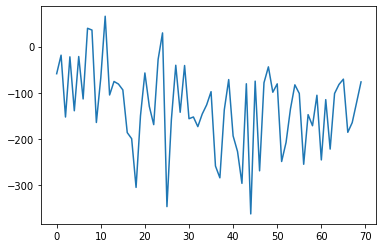

In [40]:
plt.plot(scores)